# Importing required libraries

We will need pandas , numpy and seaborn to extract, process and plot the data sequentially.

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import normalize

# Data Extraction , Processing and Feture Extraction

## Data Extraction

Our Dataset  is divided into multiple sections as :

- Baseline Features: Column-3 to Column-23
- Intensity Parameters: Col24 to Col26
- Formant Frequencies: Col27 to Col30
- Bandwidth Parameters: Col31 to Col34
- Vocal Fold: Col35 to Col56
- MFCC: Col57 to Col140
- Wavelet Features: Col141 to Col322
- TQWT Features: Col323 to Col754
- Class: Col755

*Refer Research Page: 6 - 9*

For our analysis, we will be using the following features:
1. Baseline Features
2. Intensity Parameters
3. Formant Frequencies
4. Bandwidth Parameters
5. MFCC Features
6. Class

Which in total we have 45 features.

In [65]:
# Helper methods for data-extraction
from helpers import read_data

In [66]:
filename = 'orginal_dataset/pd_speech_features.csv'
dataframe = read_data(filename)

y = dataframe['class']
original_df = dataframe.drop(['class'], axis=1)

#basic information of dataset
original_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RPDE                        756 non-null    float64
 1   meanPeriodPulses            756 non-null    float64
 2   numPulses                   756 non-null    int64  
 3   rapJitter                   756 non-null    float64
 4   ddpJitter                   756 non-null    float64
 5   apq11Shimmer                756 non-null    float64
 6   locDbShimmer                756 non-null    float64
 7   locPctJitter                756 non-null    float64
 8   DFA                         756 non-null    float64
 9   ppq5Jitter                  756 non-null    float64
 10  apq5Shimmer                 756 non-null    float64
 11  apq3Shimmer                 756 non-null    float64
 12  ddaShimmer                  756 non-null    float64
 13  locAbsJitter                756 non

Hence, we have dataframe with 45 features / columns and 756 datapoints / rows.

## Data Preprocessing and Feature Extraction

[Ref 1 : Working with Numerical Data](https://machinelearningmastery.com/feature-selection-with-numerical-input-data/)
[Ref 2 : Feature Selection Examples](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py)
[Ref 3 : Correlation and Standarization](https://stats.stackexchange.com/questions/220724/can-i-test-for-correlation-between-variables-before-standardize-them)

### Variance

In [67]:
# Variance check of every columns
variance_df = original_df.var().round(5)
variance_df = variance_df.sort_values(ascending=True)
variance_df.head(10)

meanPeriodPulses    0.00000
rapJitter           0.00000
locAbsJitter        0.00000
ppq5Jitter          0.00000
ddpJitter           0.00001
locPctJitter        0.00001
apq3Shimmer         0.00050
apq5Shimmer         0.00074
apq11Shimmer        0.00115
locShimmer          0.00185
dtype: float64

We can see first 6 columns with very low variance and will be excluded from our analysis.

In [68]:
# Removing columns with low variance
var_filter_df = original_df.drop(original_df.columns[0:6], axis=1)

### Outlier Detection

We are using Density based clustering model (DBSCAN) to find the outliers on the dataset. Using threshold of 90% quantile to get the farthest point from the cluster.

In [69]:
import hdbscan

model_obj = hdbscan.HDBSCAN(alpha=0.01, min_samples=5,
                            min_cluster_size=10,
                            cluster_selection_epsilon=0.01)
model_obj.fit(normalize(var_filter_df,mode='minmax'))

threshold = pd.Series(model_obj.outlier_scores_).quantile(0.9)
outliers = np.where(model_obj.outlier_scores_ > threshold)[0]
outliers

array([ 36,  40,  48,  51,  54,  71,  80, 140, 146, 149, 151, 162, 164,
       168, 186, 188, 200, 203, 205, 206, 210, 212, 225, 226, 249, 253,
       270, 285, 290, 293, 304, 305, 309, 311, 337, 339, 341, 348, 352,
       354, 375, 377, 407, 416, 421, 425, 439, 441, 448, 449, 450, 460,
       464, 465, 468, 470, 472, 504, 517, 531, 539, 543, 550, 568, 577,
       580, 603, 604, 606, 608, 620, 635, 662, 668, 683, 703])

In [70]:
var_filter_df = var_filter_df.drop(outliers, axis=0).reset_index(drop=True)
y = y.drop(outliers, axis=0).reset_index(drop=True)

## Type 1 - Processing

**Type 1** Data-preprcessing and Feature Selection uses methods like , self correlation and  F-test based selection.

### Correlation

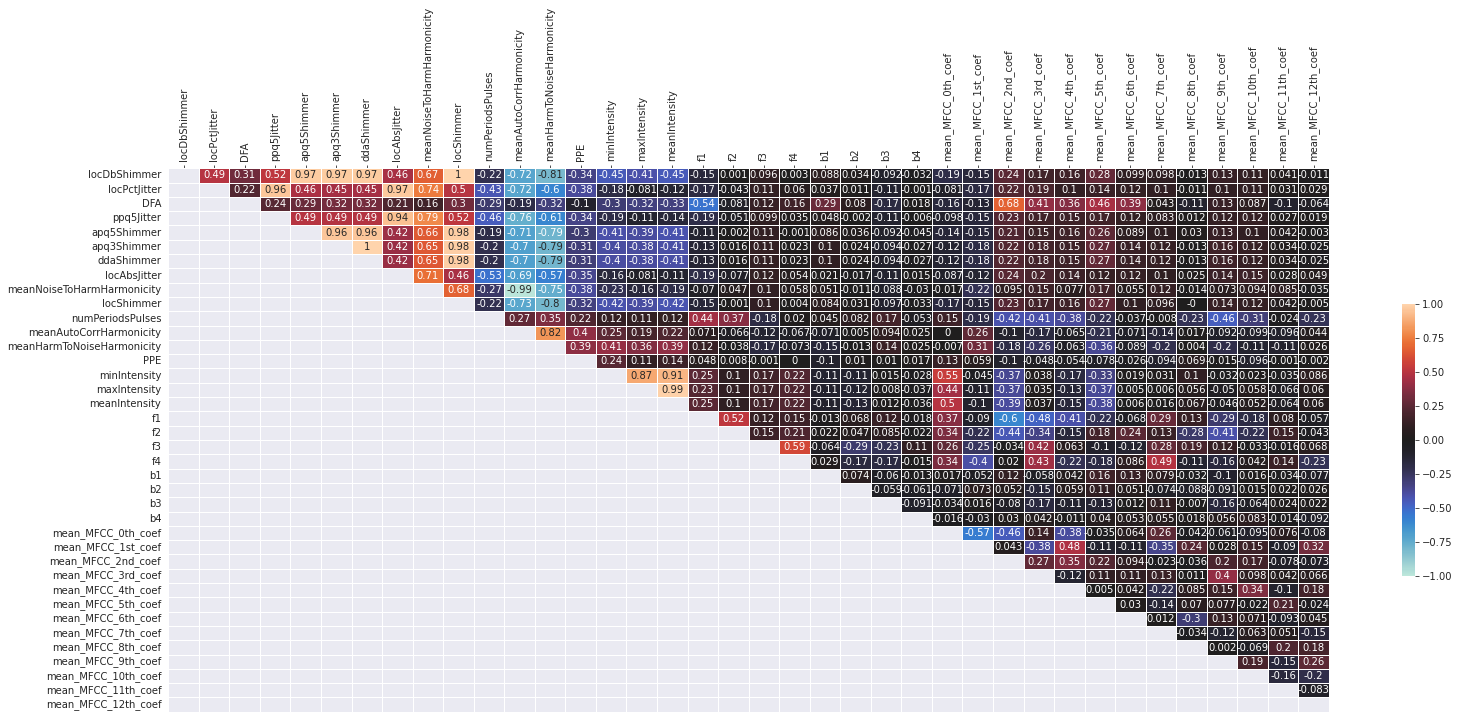

In [71]:
from helpers import correlation_heatmap, get_feature_correlation, to_remove_columns
# Drawing a heatmap of correlation between features
correlation_heatmap(var_filter_df)

Here we can see a few features pair with high correlation (positive or negative) with each other. We will remove these feature analysing their correlation with target variable.

We are filtering the features with correlation greater than *0.8*.

In [72]:
threshold = 0.8
feature_correlation_df = get_feature_correlation(var_filter_df, threshold)
feature_correlation_df

,F1,F2,Corr
38,ddaShimmer,apq3Shimmer,1.000000
39,locShimmer,locDbShimmer,0.996076
40,meanIntensity,maxIntensity,0.990759
41,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,0.987710
42,locShimmer,apq3Shimmer,0.981209
43,locShimmer,ddaShimmer,0.981209
44,locShimmer,apq5Shimmer,0.979574
45,apq3Shimmer,locDbShimmer,0.974447
46,ddaShimmer,locDbShimmer,0.974447
47,apq5Shimmer,locDbShimmer,0.974037


We can see there are 10 features pari with correlation greater than *0.8*.

In [73]:
remove_corr_columns = to_remove_columns(var_filter_df, y, feature_correlation_df)
print(f'We are require to remove {len(remove_corr_columns)} columns, which are: {remove_corr_columns}')

We are require to remove 10 columns, which are: ['apq3Shimmer', 'locShimmer', 'meanIntensity', 'meanAutoCorrHarmonicity', 'ddaShimmer', 'apq5Shimmer', 'locAbsJitter', 'ppq5Jitter', 'minIntensity', 'meanHarmToNoiseHarmonicity']


In [74]:
corr_filter_df = var_filter_df.drop(remove_corr_columns, axis=1)

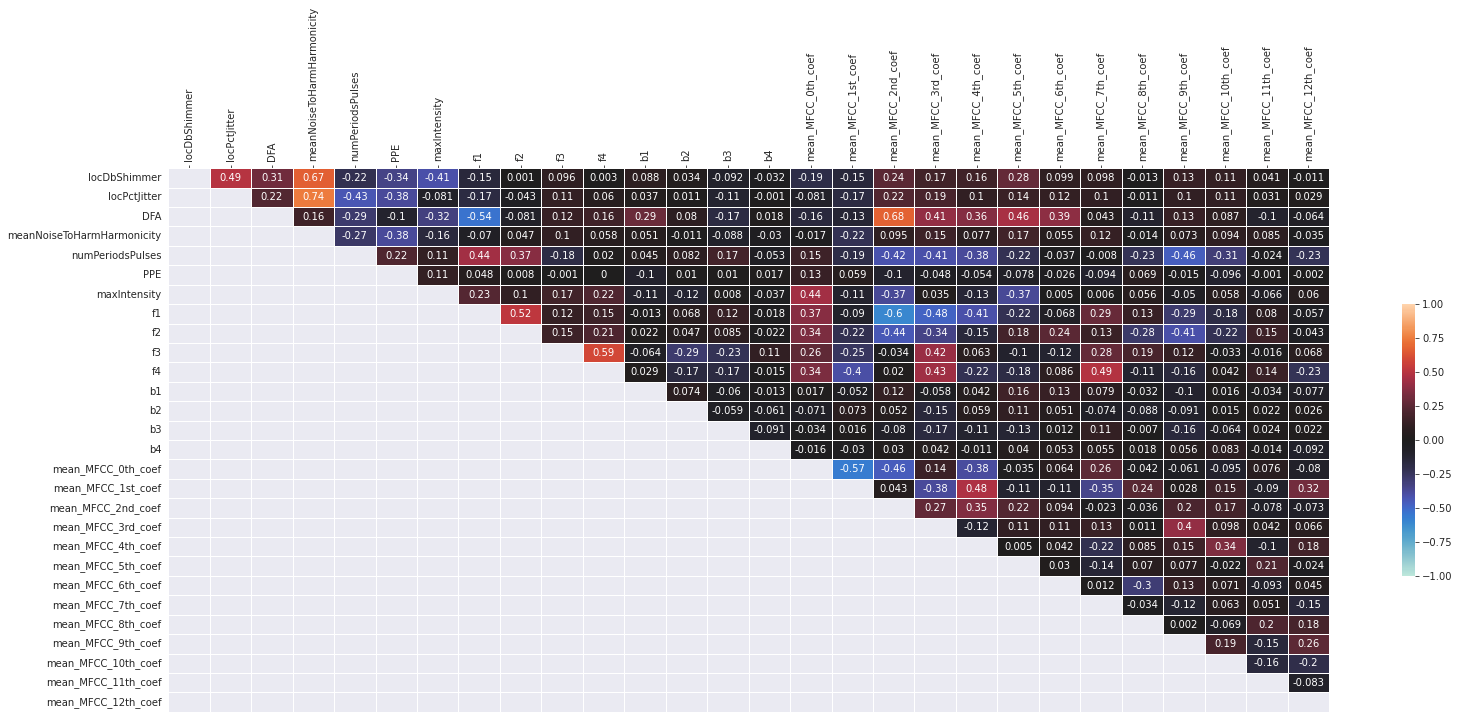

In [75]:
# Lets visualize correlation matrix
correlation_heatmap(corr_filter_df)

### Multi-collinearity Check

We will be using VIF from statsmodels library to check the multi-collinearity.
*VIF_threshold = 10*

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_threshold = 30

 # VIF dataframe
vif_data = pd.DataFrame(corr_filter_df.columns, columns=['Features'])
# calculating VIF for each feature
vif_data["VIF"] = [
    variance_inflation_factor(corr_filter_df, i)
    for i in range(len(corr_filter_df.columns))
]
# Sort VIF in descending order
vif_data.sort_values(by='VIF',ascending=False ,inplace=True)
vif_data
# vif_data[vif_data.VIF > vif_threshold]

,Features,VIF
7,f1,52.489187
18,mean_MFCC_3rd_coef,48.364773
15,mean_MFCC_0th_coef,47.683615
6,maxIntensity,47.551905
8,f2,43.798153
10,f4,40.517760
2,DFA,38.833203
9,f3,38.037337
23,mean_MFCC_8th_coef,37.213550
19,mean_MFCC_4th_coef,36.767966


We can see a few features with VIF greater than *10*. So we will remove these features.

In [77]:
to_remove_vif = vif_data[vif_data.VIF > vif_threshold].Features.tolist()
print(f'We are require to remove {len(to_remove_vif)} columns, which are: {to_remove_vif}')

multicorr_filter_data = corr_filter_df.drop(to_remove_vif, axis=1)

We are require to remove 12 columns, which are: ['f1', 'mean_MFCC_3rd_coef', 'mean_MFCC_0th_coef', 'maxIntensity', 'f2', 'f4', 'DFA', 'f3', 'mean_MFCC_8th_coef', 'mean_MFCC_4th_coef', 'mean_MFCC_5th_coef', 'mean_MFCC_1st_coef']


In [78]:
multicorr_filter_data.head()

,locDbShimmer,locPctJitter,meanNoiseToHarmHarmonicity,numPeriodsPulses,PPE,b1,b2,b3,b4,mean_MFCC_2nd_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef
0,0.223627,0.071532,0.046782,0.263274,0.936278,0.018508,0.015714,0.038401,0.064655,0.648846,0.462952,0.490180,0.524275,0.725442,0.536068,0.397303
1,0.216334,0.063181,0.022804,0.256637,0.837434,0.009498,0.016501,0.037276,0.033795,0.692990,0.432672,0.451721,0.556803,0.725314,0.550007,0.469181
2,0.408362,0.056282,0.033761,0.254425,0.934385,0.031040,0.009011,0.021416,0.010620,0.727579,0.466983,0.543941,0.541033,0.784418,0.599684,0.404354
3,0.228488,0.144517,0.054377,0.194690,0.426804,0.047585,0.041349,0.090664,0.087054,0.714858,0.623976,0.571829,0.468932,0.379552,0.374227,0.591835
4,0.213904,0.186638,0.034847,0.258850,0.330615,0.082152,0.045606,0.029939,0.062574,0.697982,0.649625,0.585323,0.458014,0.346002,0.346988,0.544923


### Class Correlation

In [79]:
# Correlation with class

correlate = np.array([multicorr_filter_data[columns].corr(y) for columns in multicorr_filter_data.columns])
corr_df = pd.DataFrame(abs(correlate.round(5)),index=multicorr_filter_data.columns,columns=['Correlation with Class'])
corr_df.sort_values(by='Correlation with Class',ascending=True)

,Correlation with Class
b2,0.00129
b1,0.02621
b4,0.04246
mean_MFCC_10th_coef,0.04390
mean_MFCC_11th_coef,0.04522
mean_MFCC_12th_coef,0.05268
b3,0.06555
PPE,0.08406
meanNoiseToHarmHarmonicity,0.09785
mean_MFCC_7th_coef,0.10276


Not a single feature has very low correlation with class. So we don't need to remove any feature.

Till now we are left with 16 features excluding *class*.

We aren't able to work with following selection tests as,

1. Chi2 because it is not applicable for numerical data.
2. Mutual Information because of smaller number of features/samples.
3. Lasso because of small number of features/samples.

### Normalization

We will be using MinMax Normalization to normalize the data.

In [80]:
normalized_df = normalize(corr_filter_df,mode='minmax')
normalized_df.head()

,locDbShimmer,locPctJitter,DFA,meanNoiseToHarmHarmonicity,numPeriodsPulses,PPE,maxIntensity,f1,f2,f3,...,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef
0,0.223627,0.099045,0.565310,0.047518,0.228650,0.949010,0.757528,0.388236,0.232903,0.501803,...,0.484759,0.727329,0.373829,0.462952,0.465842,0.600344,0.524275,0.717008,0.585317,0.397303
1,0.216334,0.087481,0.489455,0.023163,0.220386,0.848822,0.685421,0.420381,0.219573,0.470997,...,0.433574,0.714642,0.416185,0.432672,0.425547,0.619676,0.556803,0.716877,0.600537,0.469181
2,0.408362,0.077929,0.428738,0.034292,0.217631,0.947091,0.651928,0.399930,0.233383,0.458529,...,0.432013,0.691954,0.359259,0.466983,0.522169,0.581994,0.541033,0.777796,0.654778,0.404354
3,0.228488,0.200101,0.819111,0.055232,0.143251,0.432608,0.873990,0.748200,0.379249,0.844212,...,0.561108,0.446251,0.464908,0.623976,0.551388,0.750225,0.468932,0.360494,0.408608,0.591835
4,0.213904,0.258421,0.822669,0.035395,0.223140,0.335111,0.872485,0.783230,0.390901,0.867210,...,0.569242,0.420194,0.460405,0.649625,0.565527,0.761666,0.458014,0.325914,0.378867,0.544923


### Stepwise Selection

We will work with backward elimination to select the features. That means we will remove the feature with highest p-value as we go.

In [81]:
normalized_df.shape, y.shape

((680, 28), (680,))

In [82]:
from helpers import BackwardElimination

backward_elimination = BackwardElimination(
    normalized_df, y, scoring='roc_auc'
)
backward_elimination.fit()

SequentialFeatureSelector(direction='backward',
                          estimator=LogisticRegression(max_iter=500,
                                                       penalty='none'),
                          n_features_to_select='auto', n_jobs=-1,
                          scoring='roc_auc', tol=0.05)

In [83]:
final_df_step1 = backward_elimination.get_transformed_data()
final_df_step1.head()

,locDbShimmer,locPctJitter,DFA,meanNoiseToHarmHarmonicity,numPeriodsPulses,PPE,maxIntensity,f1,f2,f3,...,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_12th_coef
0,0.223627,0.099045,0.565310,0.047518,0.228650,0.949010,0.757528,0.388236,0.232903,0.501803,...,0.665434,0.484759,0.727329,0.373829,0.462952,0.465842,0.600344,0.524275,0.717008,0.397303
1,0.216334,0.087481,0.489455,0.023163,0.220386,0.848822,0.685421,0.420381,0.219573,0.470997,...,0.710706,0.433574,0.714642,0.416185,0.432672,0.425547,0.619676,0.556803,0.716877,0.469181
2,0.408362,0.077929,0.428738,0.034292,0.217631,0.947091,0.651928,0.399930,0.233383,0.458529,...,0.746180,0.432013,0.691954,0.359259,0.466983,0.522169,0.581994,0.541033,0.777796,0.404354
3,0.228488,0.200101,0.819111,0.055232,0.143251,0.432608,0.873990,0.748200,0.379249,0.844212,...,0.733133,0.561108,0.446251,0.464908,0.623976,0.551388,0.750225,0.468932,0.360494,0.591835
4,0.213904,0.258421,0.822669,0.035395,0.223140,0.335111,0.872485,0.783230,0.390901,0.867210,...,0.715826,0.569242,0.420194,0.460405,0.649625,0.565527,0.761666,0.458014,0.325914,0.544923


---

## Type 2 - Processing

**Type 2** Data-preprcessing and Feature Selection uses methods like , PCA-based selection, PCA-based selection with correlation.

### PCA

In [84]:
from helpers import pca_dataframe

pca_df = pca_dataframe(
    normalize(var_filter_df,'minmax'),
    prob=0.1
)

/home/shailesh/Desktop/fuse-project-1/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [85]:
pca_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,PCA31
0,0.042098,0.348775,-0.124754,-0.138381,-0.110355,-0.272114,-0.270084,0.108831,-0.136729,0.047383,...,0.031770,0.037863,0.039303,-0.015506,0.021190,-0.031849,-0.011702,-0.020450,-0.043300,-0.002916
1,-0.019120,0.426019,-0.026479,-0.178206,-0.074756,-0.301734,-0.192132,0.092580,-0.072341,0.080259,...,0.033095,-0.010831,-0.020122,-0.009564,0.025058,-0.014091,-0.027223,-0.006566,0.010603,-0.035268
2,0.340378,0.279443,0.069055,-0.106270,-0.013442,-0.271919,-0.366436,0.282530,-0.114010,0.017394,...,0.076342,0.051821,0.005827,0.015848,0.013943,0.009328,0.011539,-0.003204,-0.018444,-0.016641
3,0.079435,-0.121355,-0.455066,0.019664,-0.133725,-0.314021,0.029819,-0.379034,0.244700,-0.093705,...,-0.040574,-0.006276,0.026943,0.018656,0.073058,-0.004101,-0.037922,-0.020328,-0.054811,-0.051666
4,0.103385,-0.203535,-0.439613,0.060332,-0.155146,-0.305954,0.046531,-0.374814,0.288620,-0.116294,...,-0.011604,-0.037369,0.021542,-0.021595,0.043720,-0.007437,-0.027049,-0.030319,-0.009803,0.000954


With PCA Dimensionality Reduction , we get *31* independent features out of *38* features.
These 31 features can represent 90% of the original features.

### Class Correlation

In [86]:
# Correlation with class

class_correlate = np.array([pca_df[columns].corr(y) for columns in pca_df.columns])
corr_df_2 = pd.DataFrame(
    abs(class_correlate.round(5)),index=pca_df.columns, columns=['Correlation with Class']
)
corr_df_2.sort_values(by='Correlation with Class',ascending=True)

,Correlation with Class
PCA28,0.00037
PCA18,0.00878
PCA25,0.01404
PCA11,0.02626
PCA19,0.02796
PCA24,0.02880
PCA21,0.03351
PCA26,0.04025
PCA15,0.04349
PCA27,0.04555


Not a single feature has very low correlation with class. So we don't need to remove any feature.

### Stepwise Selection

We will work with backward elimination to select the features. That means we will remove the feature with highest p-value as we go.

In [87]:
from helpers import BackwardElimination

backward_elimination = BackwardElimination(
    pca_df, y, scoring='roc_auc'
)
backward_elimination.fit()

SequentialFeatureSelector(direction='backward',
                          estimator=LogisticRegression(max_iter=500,
                                                       penalty='none'),
                          n_features_to_select='auto', n_jobs=-1,
                          scoring='roc_auc', tol=0.05)

In [88]:
final_df_step2 = backward_elimination.get_transformed_data()
final_df_step2.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA9,PCA10,PCA11,...,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,PCA31
0,0.042098,0.348775,-0.124754,-0.138381,-0.110355,-0.272114,-0.270084,-0.136729,0.047383,0.106243,...,0.031770,0.037863,0.039303,-0.015506,0.021190,-0.031849,-0.011702,-0.020450,-0.043300,-0.002916
1,-0.019120,0.426019,-0.026479,-0.178206,-0.074756,-0.301734,-0.192132,-0.072341,0.080259,0.033485,...,0.033095,-0.010831,-0.020122,-0.009564,0.025058,-0.014091,-0.027223,-0.006566,0.010603,-0.035268
2,0.340378,0.279443,0.069055,-0.106270,-0.013442,-0.271919,-0.366436,-0.114010,0.017394,0.104803,...,0.076342,0.051821,0.005827,0.015848,0.013943,0.009328,0.011539,-0.003204,-0.018444,-0.016641
3,0.079435,-0.121355,-0.455066,0.019664,-0.133725,-0.314021,0.029819,0.244700,-0.093705,-0.124618,...,-0.040574,-0.006276,0.026943,0.018656,0.073058,-0.004101,-0.037922,-0.020328,-0.054811,-0.051666
4,0.103385,-0.203535,-0.439613,0.060332,-0.155146,-0.305954,0.046531,0.288620,-0.116294,-0.200425,...,-0.011604,-0.037369,0.021542,-0.021595,0.043720,-0.007437,-0.027049,-0.030319,-0.009803,0.000954


# Finalizing

In [89]:
y

0      1
1      1
2      1
3      1
4      1
      ..
675    0
676    0
677    0
678    0
679    0
Name: class, Length: 680, dtype: int64

In [90]:
or_len = len(original_df.columns)
s1_len = len(final_df_step1.columns)
s2_len = len(final_df_step2.columns)

col_diff_S1 = set(original_df.columns) - set(final_df_step1.columns)


print(f'We have {s1_len} features in Type-1 pre-processed dataset and {s2_len} features in'
      f'Type-2 pre-processed dataset. That is difference of {or_len - s1_len} and '
      f'{or_len - s2_len} features from original dataset respectively.')
print()
print(f'We have removed {len(col_diff_S1)} features: {col_diff_S1} from Type-1 pre-processed dataset \n and {or_len - s2_len} features from Type-2 pre-processed dataset.')

We have 27 features in Type-1 pre-processed dataset and 30 features inType-2 pre-processed dataset. That is difference of 17 and 14 features from original dataset respectively.

We have removed 17 features: {'apq11Shimmer', 'ppq5Jitter', 'apq5Shimmer', 'apq3Shimmer', 'ddaShimmer', 'RPDE', 'meanPeriodPulses', 'meanIntensity', 'minIntensity', 'locShimmer', 'numPulses', 'rapJitter', 'meanAutoCorrHarmonicity', 'meanHarmToNoiseHarmonicity', 'mean_MFCC_11th_coef', 'ddpJitter', 'locAbsJitter'} from Type-1 pre-processed dataset 
 and 14 features from Type-2 pre-processed dataset.


In [91]:
final_df_step1['class'] = y
final_df_step2['class'] = y

final_df_step1.to_csv('processed_dataset/final_data_S1.csv', index=False)
final_df_step2.to_csv('processed_dataset/final_data_S2.csv', index=False)